In [9]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import torch
import torchvision.datasets as dsets
from torchvision import transforms

from util import bfs, traverse_to_node, unpack_tree

In [29]:
np.random.seed(0)

# Prepare the data
num_samples = 100
num_classes = 3
X = np.random.rand(num_samples, 4)
y = np.random.randint(0, num_classes, size=(num_samples,))

def predict(clfs, x):
    preds = []
    for clf in clfs:
        preds.append(clf.predict(x)[0])
    return max(set(preds), key=preds.count)

def fit_ensemble(X, y, n_clfs=5):
    clfs = []
    for i in range(n_clfs):
        print(f'Training clf: {i}')
        ix = np.random.choice(range(X.shape[0]), X.shape[0] // 5)
        X_ = X[ix]
        y_ = y[ix]

        clf = DecisionTreeClassifier(random_state=i)
        model = clf.fit(X_, y_)

        clfs.append(clf)
    return clfs

clfs = fit_ensemble(X, y)

Training clf: 0
Training clf: 1
Training clf: 2
Training clf: 3
Training clf: 4


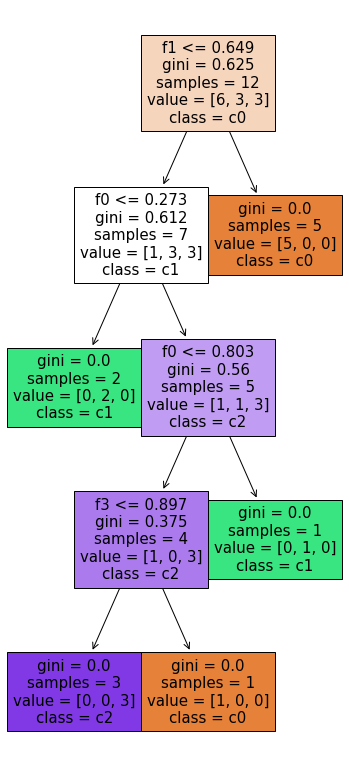

In [22]:
fig = plt.figure(figsize=(6, 14))
_ = tree.plot_tree(clfs[0], 
                   feature_names=[f'f{i}' for i in range(X.shape[1])],  
                   class_names=[f'c{i}' for i in set(y)],
                   filled=True)
plt.show()

In [23]:
def get_constraints(clf, sample, target_cls=0):
    root, feature, threshold = unpack_tree(clf)
    
    # Get the leaf node
    node, _ = traverse_to_node(root, sample, feature, threshold)

    # Get the shortest path from the leaf node to the target class's leaf node
    path = bfs(node, target_cls=target_cls)
    # Index of the top-most parent
    ix = path[::-1].index('parent')

    # Travel up to the top-most parent
    for dir in path[:-ix]:
        node = node.parent

    constraints = []
    # Don't change each feature in the remaining path,
    # add it to constraints
    for dir in path[-ix:]:
        thresh = threshold[node.id]
        feat = feature[node.id]

        if dir == 'left':
            constraints.append((f'f{feat}', '<=', thresh))
            node = node.left
        else:
            constraints.append((f'f{feat}', '>', thresh))
            node = node.right

    return constraints

In [30]:
sample = X[1]
target_cls = 1

for i, clf in enumerate(clfs):
    actual_label = clf.predict([sample])[0]

    if actual_label == target_cls:
        print(f"Classifier {i}: No feature needs to be modified")
        continue
    constraints = get_constraints(
        clf,
        sample,
        target_cls=target_cls
    )

    print(f"Classifier {i}: {constraints}")

Classifier 0: No feature needs to be modified
Classifier 1: [('f0', '<=', 0.25954052060842514)]
Classifier 2: [('f1', '<=', 0.283722460269928)]
Classifier 3: [('f3', '<=', 0.5656466782093048)]
Classifier 4: [('f0', '>', 0.9223829805850983), ('f3', '<=', 0.654712051153183)]
